# Coexisting processes (SIR + UAU) + multilayer (AUCS)

This experiment shows the difference between SIR and SIR + UAU

In [2]:
import matplotlib.pyplot as plt
import network_diffusion as nd
import numpy as np
import pandas as pd

from tqdm import tqdm
from utils import functions, models, networks

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
N_EPOCHS = 20
N_REPETITIONS = 1000
PATIENCE = None
LAMBDAS = [0, 0.5, 1, 1.5, 2]

In [4]:
net = networks.get_aucs_network()
# net = networks.get_sf_net()
# net = networks.get_er_net()
print(net)

network parameters
--------------------------------------------
general parameters:
	number of layers: 2
	number of actors: 60

layer 'contagion' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 60
	number of edges - 194
	average degree - 6.4667
	clustering coefficient - 0.6396

layer 'awareness' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 60
	number of edges - 124
	average degree - 4.1333
	clustering coefficient - 0.2882


In [5]:
results = {}

for l in LAMBDAS:
    print(f"Model with lambda: {l}")
    model = models.get_covid_model(l=l)

    all_logs = []
    for i in tqdm(range(N_REPETITIONS)):
        experiment = nd.Simulator(model, net.copy())
        run_logs = experiment.perform_propagation(n_epochs=N_EPOCHS, patience=PATIENCE)
        all_logs.append(run_logs._global_stats_converted)

    mean_contagion = functions.get_mean_log([log["contagion"] for log in all_logs])
    mean_awareness = functions.get_mean_log([log["awareness"] for log in all_logs])
    mean_core = pd.DataFrame([mean_contagion["I"], mean_awareness["A"]]).T

    std_contagion = functions.get_std_log([log["contagion"] for log in all_logs])
    std_awareness = functions.get_std_log([log["awareness"] for log in all_logs])
    std_core = pd.DataFrame([std_contagion["I"], std_awareness["A"]]).T

    results[l] = {"mean": mean_core, "std": std_core}

print(model)

Model with lambda: 0


100%|██████████| 1000/1000 [00:46<00:00, 21.42it/s]


Model with lambda: 0.5


100%|██████████| 1000/1000 [00:47<00:00, 21.23it/s]


Model with lambda: 1


100%|██████████| 1000/1000 [00:48<00:00, 20.54it/s]


Model with lambda: 1.5


100%|██████████| 1000/1000 [00:47<00:00, 21.23it/s]


Model with lambda: 2


100%|██████████| 1000/1000 [00:48<00:00, 20.58it/s]


DSAA Model
--------------------------------------------
compartmental model
--------------------------------------------
processes, their states and initial sizes:
	'contagion': [S:95%, I:2.5%, R:2.5%]
	'awareness': [U:95%, A:5%]
--------------------------------------------
process 'contagion' transitions with nonzero weight:
	from S to I with probability 0.19 and constrains ['awareness.U']
	from I to R with probability 0.1 and constrains ['awareness.U']
	from S to I with probability 0.025713703814956412 and constrains ['awareness.A']
	from I to R with probability 0.7389056098930651 and constrains ['awareness.A']
--------------------------------------------
process 'awareness' transitions with nonzero weight:
	from U to A with probability 0.05 and constrains ['contagion.S']
	from U to A with probability 0.75 and constrains ['contagion.I']
	from U to A with probability 0.05 and constrains ['contagion.R']
seed selection method
--------------------------------------------
	nodewise random

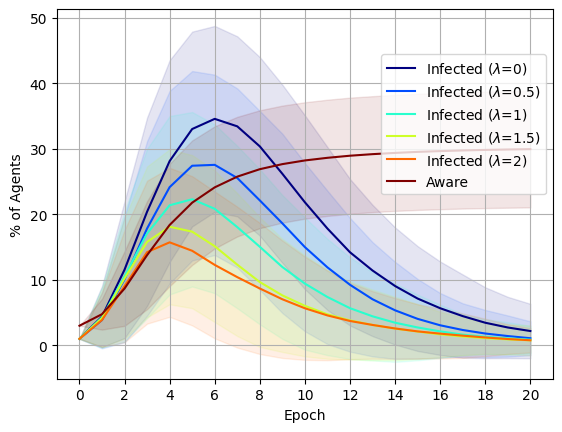

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1)
colors = plt.cm.jet(np.linspace(0, 1, len(results) + 1))
res_nb = 0

for l, result in results.items():

    _i = result["mean"]["I"].to_numpy()
    _i_std = result["std"]["I"].to_numpy()
    _x = np.arange(0, len(_i))

    # _x_new = np.linspace(_x.min(), _x.max(), 300)
    # _i_new = make_interp_spline(_x, _i, k=1)(_x_new)

    ax.plot(_x, _i, label=rf"Infected ($\lambda$={l})", color=colors[res_nb])
    ax.fill_between(_x, _i-_i_std, _i+_i_std, alpha=0.1, color=colors[res_nb])

    res_nb += 1


_a = np.array([_r["mean"]["A"] for _r in results.values()]).mean(0)
_a_std = np.array([_r["std"]["A"] for _r in results.values()]).mean(0)

ax.plot(_x, _a, label="Aware", color=colors[res_nb])
ax.fill_between(_x, _a-_a_std, _a+_a_std, alpha=0.1, color=colors[res_nb])

ax.grid(True)
ax.set_xlabel("Epoch")
ax.set_xticks(np.arange(0, _x.max()+1, 2))
ax.set_ylabel("% of Agents")
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.8))
